In [143]:
# tool kit
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [2]:
#Ho: Não é estacionário
#H1: É estacionário

def adfuller_test(Vendas):
    
    result=adfuller(Vendas)
    
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
   
    # se a significância estiver abaixo de 0.05, significa que há pouca influência nos dados. 
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis, indicating it is non-stationary ")

In [132]:
df=pd.read_csv('Dados/data_tratado.csv', sep=";")  

In [133]:
df.loc[:,'DT_MEDICAO'] =  pd.to_datetime(df.loc[:,'DT_MEDICAO'], format='%Y-%m-%d')

In [134]:
#Criando uma time series da Radiação
ts= df[['DT_MEDICAO','RAD']]

In [135]:
#Indexando a Time Series
ts.set_index('DT_MEDICAO', drop=True, inplace=True)

In [136]:
#Somando a Radiação e agrupando por dia
ts = ts.resample('d').sum()

In [126]:
ts

,RAD
DT_MEDICAO,
2015-01-01,28172.702
2015-01-02,21412.210
2015-01-03,13982.863
2015-01-04,13622.406
2015-01-05,14505.361
...,...
2021-12-27,21132.838
2021-12-28,18349.341
2021-12-29,26594.520


<AxesSubplot:xlabel='DT_MEDICAO'>

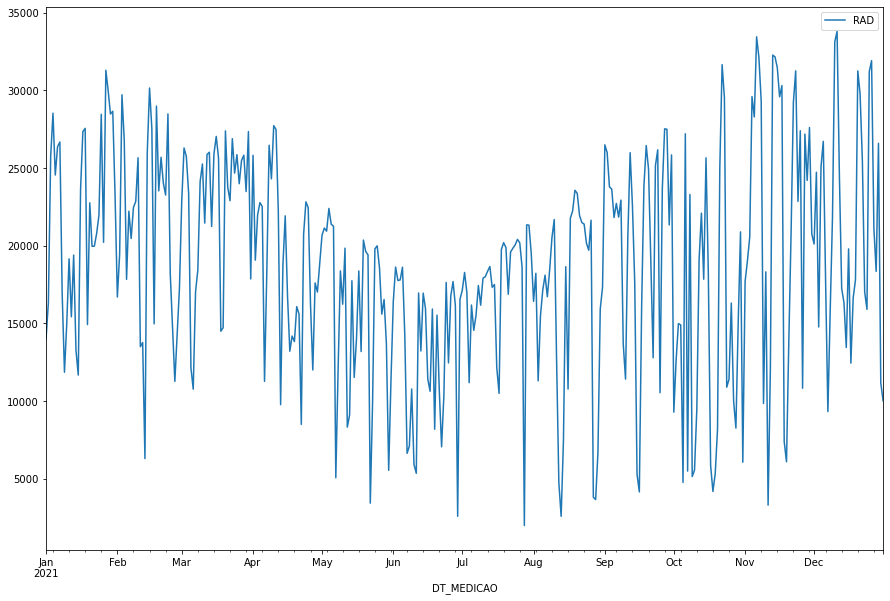

In [113]:
ts.loc['2021-1-1':].plot(figsize=(15,10))

array([[<AxesSubplot:title={'center':'RAD'}>]], dtype=object)

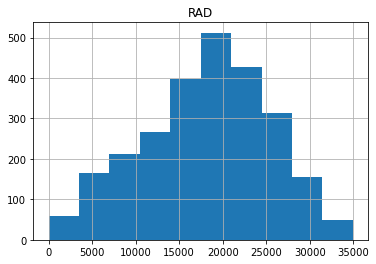

In [114]:
# distribuição da série
ts.hist()

<AxesSubplot:ylabel='Density'>

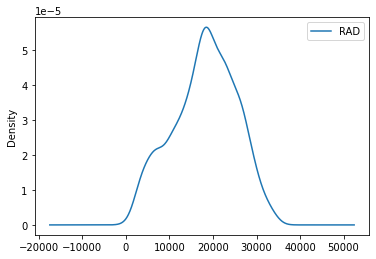

In [115]:
# densidade
ts.plot(kind = 'kde')

<AxesSubplot:>

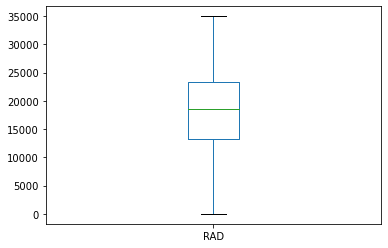

In [116]:
# boxplot
ts.plot(kind = 'box')

In [128]:
ts_df = ts

In [130]:
ts_df['month_name'] = ts_df.index.month_name()
ts_df['day_name'] = ts_df.index.day_name()

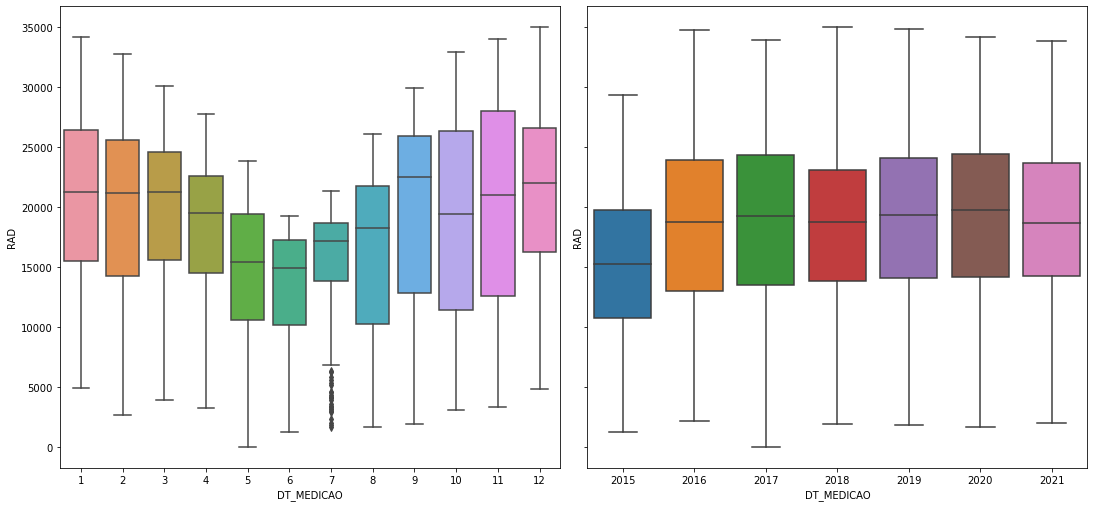

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(15,7), sharey=True)
fig.tight_layout()
sns.boxplot(x=ts.index.month, y=ts.iloc[:, 0], orient='v', ax=ax[0])
sns.boxplot(x=ts.index.year, y=ts.iloc[:, 0], orient='v', ax=ax[1]);

In [137]:
# variação percentual
(ts.pct_change().fillna(0)*100).round(2)

,RAD
DT_MEDICAO,
2015-01-01,0.00
2015-01-02,-24.00
2015-01-03,-34.70
2015-01-04,-2.58
2015-01-05,6.48
...,...
2021-12-27,-33.79
2021-12-28,-13.17
2021-12-29,44.93


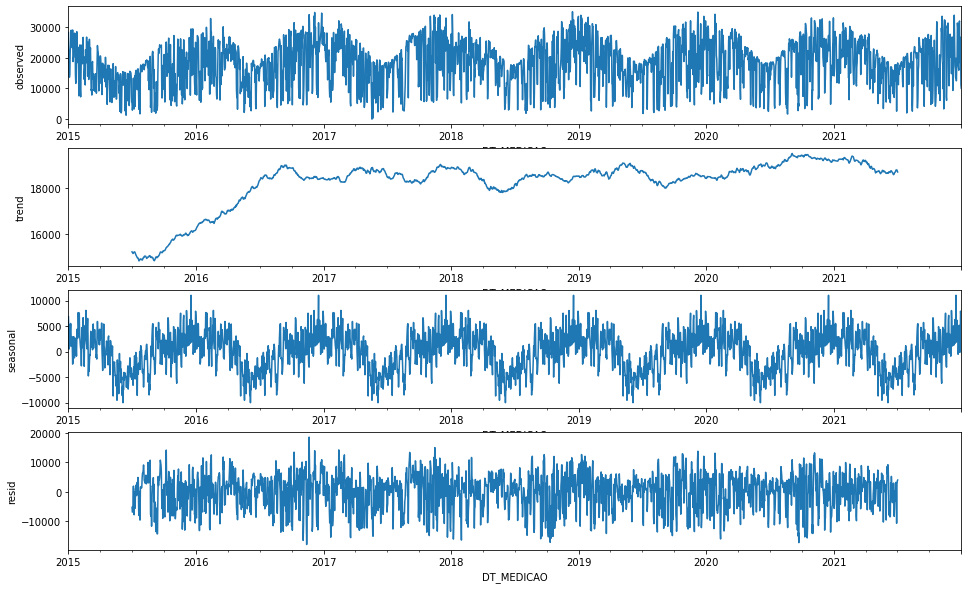

In [138]:
# Vamos realizar uma decomposição aditiva da nossa série, e estudar sua tendência, sazonalidade e resíduo.
decomposition = seasonal_decompose(ts, freq=365)

fig, ax = plt.subplots(4, 1, figsize=(16, 10))
decomposition.observed.plot(ax=ax[0]); ax[0].set_ylabel('observed')
decomposition.trend.plot(ax=ax[1]); ax[1].set_ylabel('trend')
decomposition.seasonal.plot(ax=ax[2]); ax[2].set_ylabel('seasonal')
decomposition.resid.plot(ax=ax[3]); ax[3].set_ylabel('resid');

In [139]:
adfuller_test(ts)

ADF Test Statistic : -5.892094901748089
p-value : 2.908276319942442e-07
#Lags Used : 20
Number of Observations Used : 2536
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


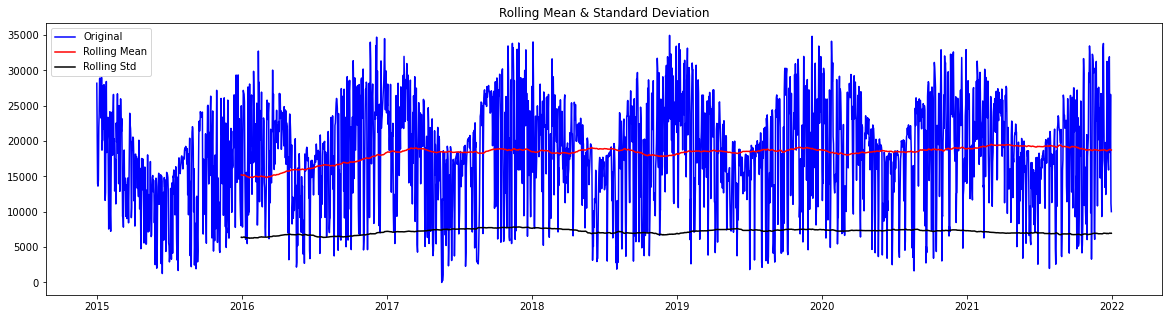

In [46]:
ts_log = np.log(ts)
#Determing rolling statistics
rolmean = ts.rolling(365).mean()
rolstd = ts.rolling(365).std()

#Plot rolling statistics:
plt.figure(figsize = (20, 5))
orig = plt.plot(ts, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

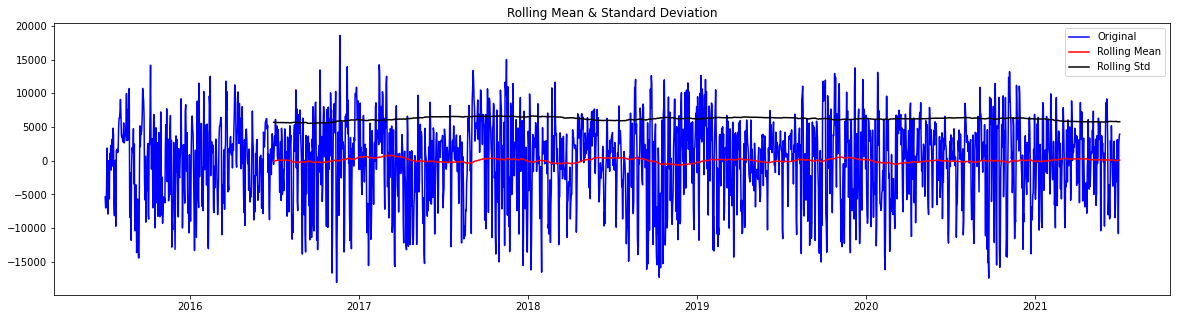

In [197]:
#Verificando o residuo, se assemelha a um ruido Branco
rolmean = decomposition.resid.rolling(365).mean()
rolstd = decomposition.resid.rolling(365).std()

plt.figure(figsize = (20, 5))
orig = plt.plot(decomposition.resid, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

## Previsão

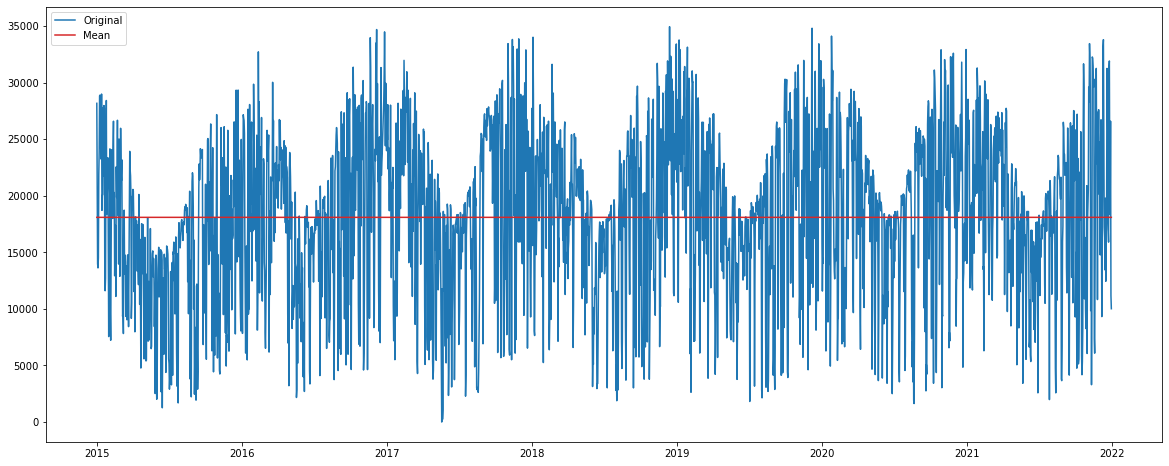

In [29]:
# Será q a média consegue descrever bem nossa distribuição?
plt.figure(figsize=(20, 8))
plt.plot(ts, color='C0',label='Original')
plt.plot(ts.index, [ts['RAD'].mean() for _ in ts.index], label=f'Mean', c='C03');
plt.legend();

### ARIMA

In [155]:
# fit model
model = ARIMA(ts['RAD'], order=(3, 0, 1))
model_fit = model.fit(disp=0)

# predict
start_index = pd.datetime(2015, 1, 1)
end_index = pd.datetime(2022, 12, 1)
forecast = model_fit.predict()

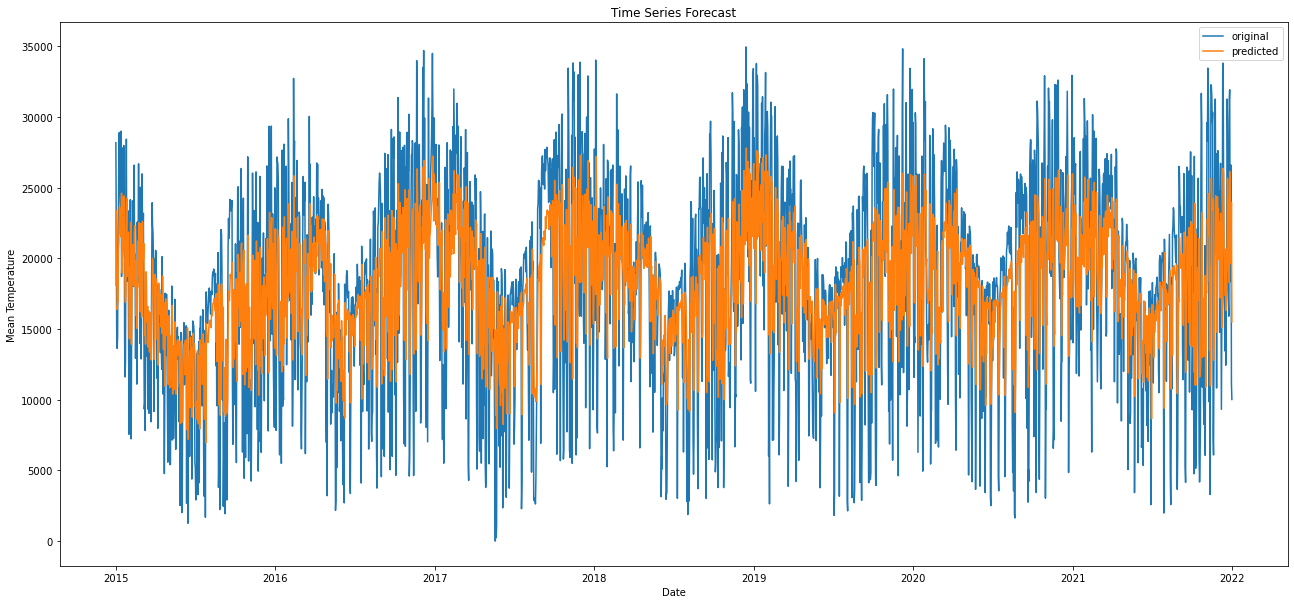

In [156]:
# visualization
plt.figure(figsize=(22,10))
plt.plot(ts['RAD'].index, ts['RAD'], label = "original")
plt.plot(forecast, label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

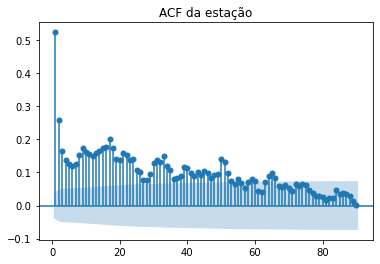

In [173]:
plot_acf(ts,lags=90,zero=False,title="ACF da estação");

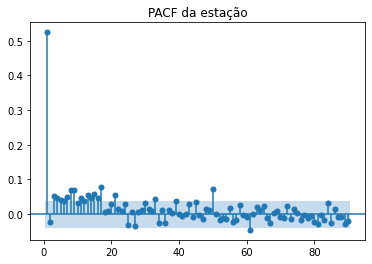

In [174]:
plot_pacf(ts,lags=90,zero=False,title="PACF da estação");

In [161]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                    RAD   No. Observations:                 2557
Model:                     ARMA(3, 1)   Log Likelihood              -25893.982
Method:                       css-mle   S.D. of innovations           6048.886
Date:                Tue, 22 Mar 2022   AIC                          51799.964
Time:                        20:05:22   BIC                          51835.044
Sample:                    01-01-2015   HQIC                         51812.685
                         - 12-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.809e+04    730.851     24.756      0.000    1.67e+04    1.95e+04
ar.L1.RAD      1.4514      0.022     67.046      0.000       1.409       1.494
ar.L2.RAD     -0.5490      0.033    -16.547      0.0

### Auto Arima

In [175]:
modelo = auto_arima(ts, suppress_warnings=True, error_action='ignore')

In [176]:
modelo.order

(0, 1, 4)

In [177]:
previsoes = modelo.predict(n_periods=365)

In [178]:
previsoes

array([16340.30885638, 19497.69570657, 20444.32880572, 20574.1312139 ,
       20574.1312139 , 20574.1312139 , 20574.1312139 , 20574.1312139 ,
       20574.1312139 , 20574.1312139 , 20574.1312139 , 20574.1312139 ,
       20574.1312139 , 20574.1312139 , 20574.1312139 , 20574.1312139 ,
       20574.1312139 , 20574.1312139 , 20574.1312139 , 20574.1312139 ,
       20574.1312139 , 20574.1312139 , 20574.1312139 , 20574.1312139 ,
       20574.1312139 , 20574.1312139 , 20574.1312139 , 20574.1312139 ,
       20574.1312139 , 20574.1312139 , 20574.1312139 , 20574.1312139 ,
       20574.1312139 , 20574.1312139 , 20574.1312139 , 20574.1312139 ,
       20574.1312139 , 20574.1312139 , 20574.1312139 , 20574.1312139 ,
       20574.1312139 , 20574.1312139 , 20574.1312139 , 20574.1312139 ,
       20574.1312139 , 20574.1312139 , 20574.1312139 , 20574.1312139 ,
       20574.1312139 , 20574.1312139 , 20574.1312139 , 20574.1312139 ,
       20574.1312139 , 20574.1312139 , 20574.1312139 , 20574.1312139 ,
      

In [179]:
train = ts[:int(0.7*(len(ts)))]
valid = ts[int(0.7*(len(ts))):]

<AxesSubplot:xlabel='DT_MEDICAO'>

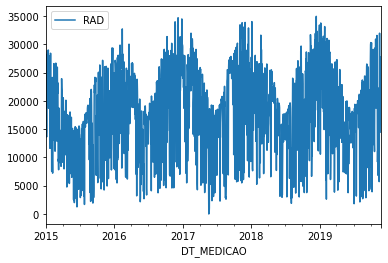

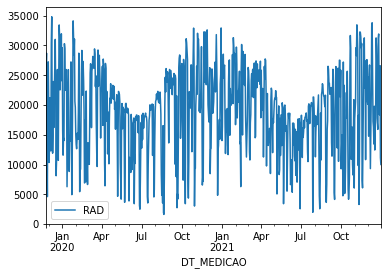

In [180]:
train.plot()
valid.plot()

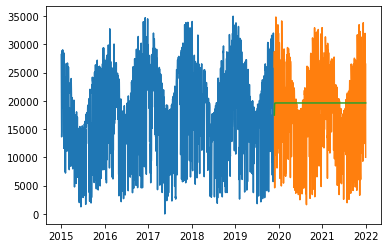

In [181]:
model = auto_arima(train, error_action='ignore', suppress_warnings=True)
model.fit(train)

forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [182]:
mean_squared_error(valid, forecast)

52040804.8798432

### FBprophet

In [183]:
import fbprophet
from fbprophet import Prophet

In [184]:
df_FB=ts.reset_index()

In [185]:
df_FB.rename(columns={'DT_MEDICAO': 'ds', 'RAD': 'y'}, inplace=True)

In [186]:
df_FB.head()

,ds,y
0,2015-01-01,28172.702
1,2015-01-02,21412.210
2,2015-01-03,13982.863
3,2015-01-04,13622.406
4,2015-01-05,14505.361


In [187]:
my_model = Prophet()

In [188]:
my_model.fit(df_FB)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


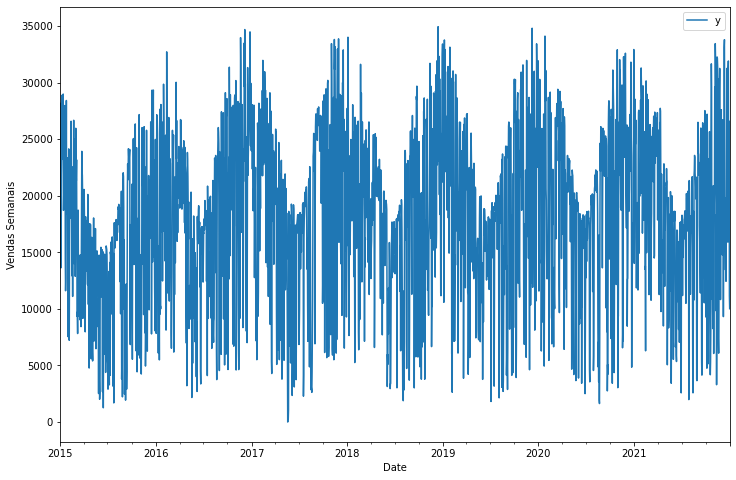

In [189]:
ax = df_FB.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Vendas Semanais')
ax.set_xlabel('Date')

plt.show()

In [190]:
future_dates = my_model.make_future_dataframe(periods=365, freq='D')
future_dates

,ds
0,2015-01-01
1,2015-01-02
2,2015-01-03
3,2015-01-04
4,2015-01-05
...,...
2917,2022-12-27
2918,2022-12-28
2919,2022-12-29
2920,2022-12-30


In [191]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2917,2022-12-27,22468.335227,13966.985801,31077.341197
2918,2022-12-28,22946.508366,15027.129280,31617.742724
2919,2022-12-29,22772.869658,14775.071845,31746.591320
2920,2022-12-30,22021.986472,14070.147208,30316.894639
2921,2022-12-31,23054.216174,14313.007543,31564.129269


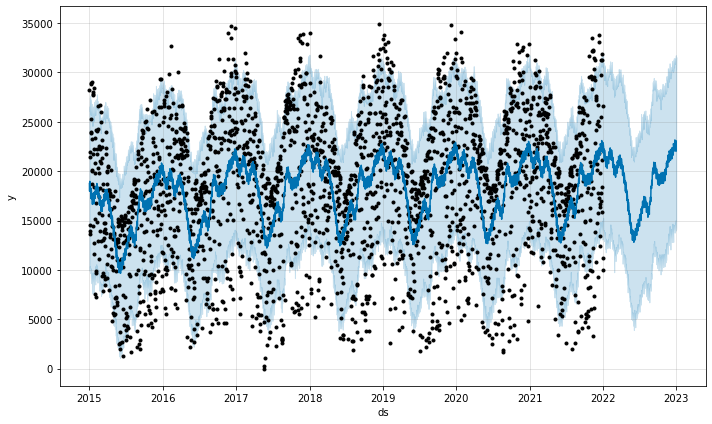

In [192]:
my_model.plot(forecast,
              uncertainty=True);

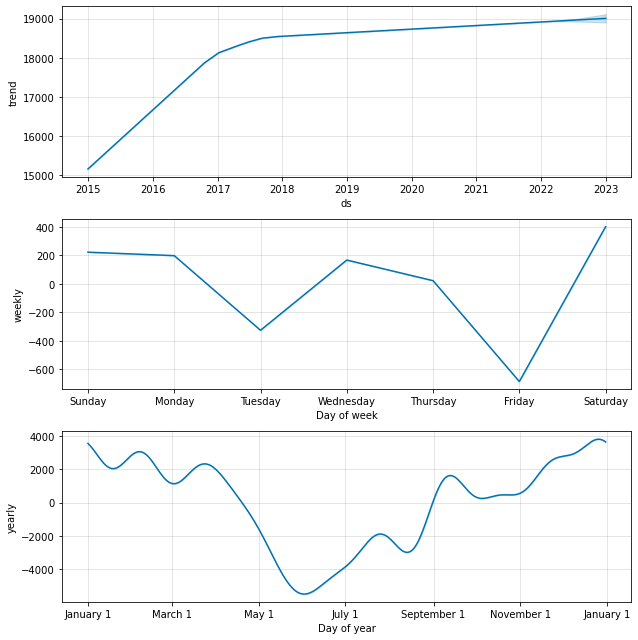

In [193]:
my_model.plot_components(forecast);